In [1]:
import cv2

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from utils.dataset import ImageSet, transform
from utils.metrics import plot_metrics
from utils.utils import fix_colors

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tomek/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/tomek/.local/lib/python3.12/site-packages/lpips/weights/v0.1/alex.pth


/home/tomek/.local/lib/python3.12/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='c

# OpenCV Scalling

In [2]:
def classic_upscale(img):
    return cv2.resize(img, [256, 256], interpolation=2) # 2 = bicubic interpolation

# Neural Network Scalling

### Dataset

In [3]:
train_dataset = ImageSet("data/scalling/train", "data/intermediate/train", transform)
valid_dataset = ImageSet("data/scalling/valid", "data/intermediate/valid", transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

### Model

In [ ]:
class UpscaleCNN(nn.Module):
    def __init__(self):
        super(UpscaleCNN, self).__init__()

        # Encoder: 32x32 -> feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )

        # Decoder: 4x4 -> 256x256 (upscaling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# model = UpscaleCNN()
# model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.MSELoss()

In [7]:
# import tqdm

# num_epochs = 10

# losses = {"train":[],"val":[]}

# for epoch in range(num_epochs):
#     model.train()
#     for x, y in tqdm.tqdm(train_dataloader):
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad() 
#         out = model(x)
#         print(out.shape, y.shape)
#         loss = criterion(out, y)

#         loss.backward()
#         optimizer.step()
    
#     model.eval()
#     print(f"epoch #{epoch+1}, loss: {loss}")
#     losses["train"].append(loss)
#     with torch.no_grad():
#         total_loss = 0.0
#         for x, y in valid_dataset:
#             x, y = x.to(device), y.to(device)
#             out = model(x)

#             loss = criterion(out, y)

#             total_loss += loss.item()
#         print("Validation loss:",total_loss)
#     losses["val"].append(total_loss)

In [8]:
# x = range(num_epochs)
# y = losses['val']

# plt.plot(x[:50], y[:50])
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.title("loss on valid")
# plt.show()

In [9]:
# torch.save(model, "model_scaling.pth")

## Results

In [10]:
model = torch.load('model_scaling.pth')
model.to(device)

/tmp/ipykernel_205825/1169627950.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_scaling.pth')


AttributeError: Can't get attribute 'UpscaleCNN' on <module '__main__'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.059639994..1.0542567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12476354..1.2002606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008724349..0.9939914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11744143..1.188814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054759048..0.9754235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12476354..1.2002606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

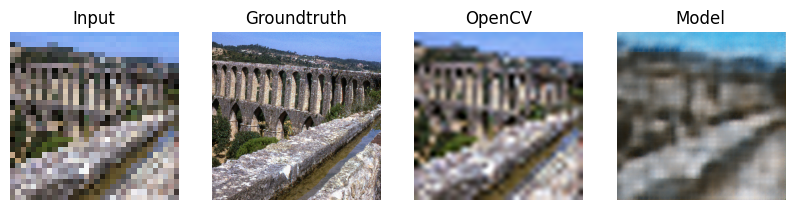

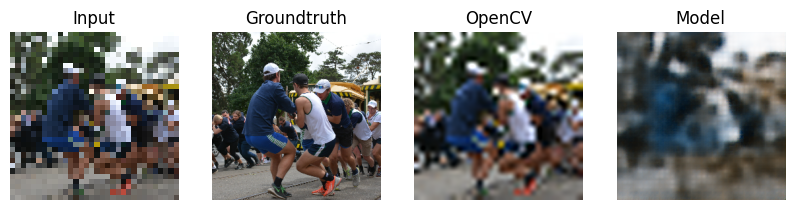

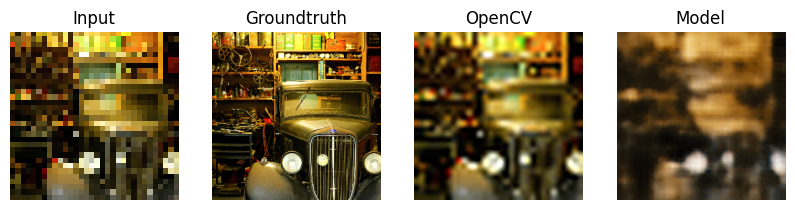

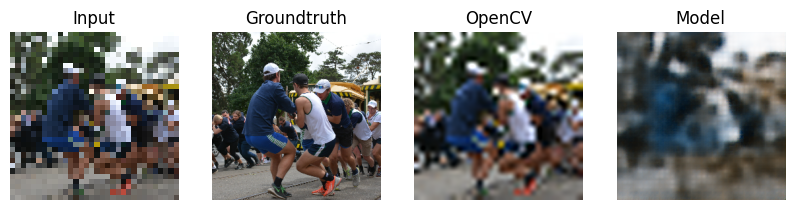

In [ ]:
for i in range(4):
    a = random.choice(valid_dataset)

    model.eval()

    input = a[0].permute(1, 2, 0).detach().numpy()

    out = model(a[0].to(device))
    out = out.permute(1, 2, 0).detach().cpu().numpy()

    dest = a[1].permute(1, 2, 0).detach().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(10, 5)) 

    axes[0].imshow(fix_colors(input))
    axes[0].axis('off')
    axes[0].set_title("Input")

    axes[1].imshow(fix_colors(dest))
    axes[1].axis('off')
    axes[1].set_title("Groundtruth")

    axes[2].imshow(fix_colors(classic_upscale(input)))
    axes[2].axis('off')
    axes[2].set_title("OpenCV")

    axes[3].imshow(fix_colors(out))
    axes[3].axis('off')
    axes[3].set_title("Model")

### Metrics

[[[0.8983087  0.87157017 0.83600485]
  [0.90099865 0.8691724  0.8411321 ]
  [0.90834314 0.87685925 0.83471197]
  ...
  [0.8463758  0.86207277 0.89271915]
  [0.81470424 0.89619005 0.8992388 ]
  [0.88969725 0.8449088  0.87476045]]

 [[0.90504766 0.8591361  0.8420313 ]
  [0.9073352  0.87916094 0.85129464]
  [0.9129128  0.8779314  0.8437339 ]
  ...
  [0.84453285 0.89216894 0.9292248 ]
  [0.86112773 0.8855009  0.9266524 ]
  [0.8742865  0.85392934 0.90156585]]

 [[0.90023607 0.88405263 0.84418267]
  [0.9157643  0.88148475 0.85299504]
  [0.9104041  0.8837819  0.8496455 ]
  ...
  [0.8488916  0.8998547  0.93083876]
  [0.8326756  0.9147468  0.9461863 ]
  [0.85312736 0.91033137 0.87442434]]

 ...

 [[0.1437098  0.28475115 0.36799774]
  [0.12548763 0.2651783  0.36346596]
  [0.10995132 0.27829444 0.37895185]
  ...
  [0.31094018 0.44118455 0.5197611 ]
  [0.23651941 0.45308858 0.4796411 ]
  [0.25386247 0.38571545 0.46644595]]

 [[0.16592363 0.26177657 0.3760024 ]
  [0.14737695 0.26714042 0.36592805]


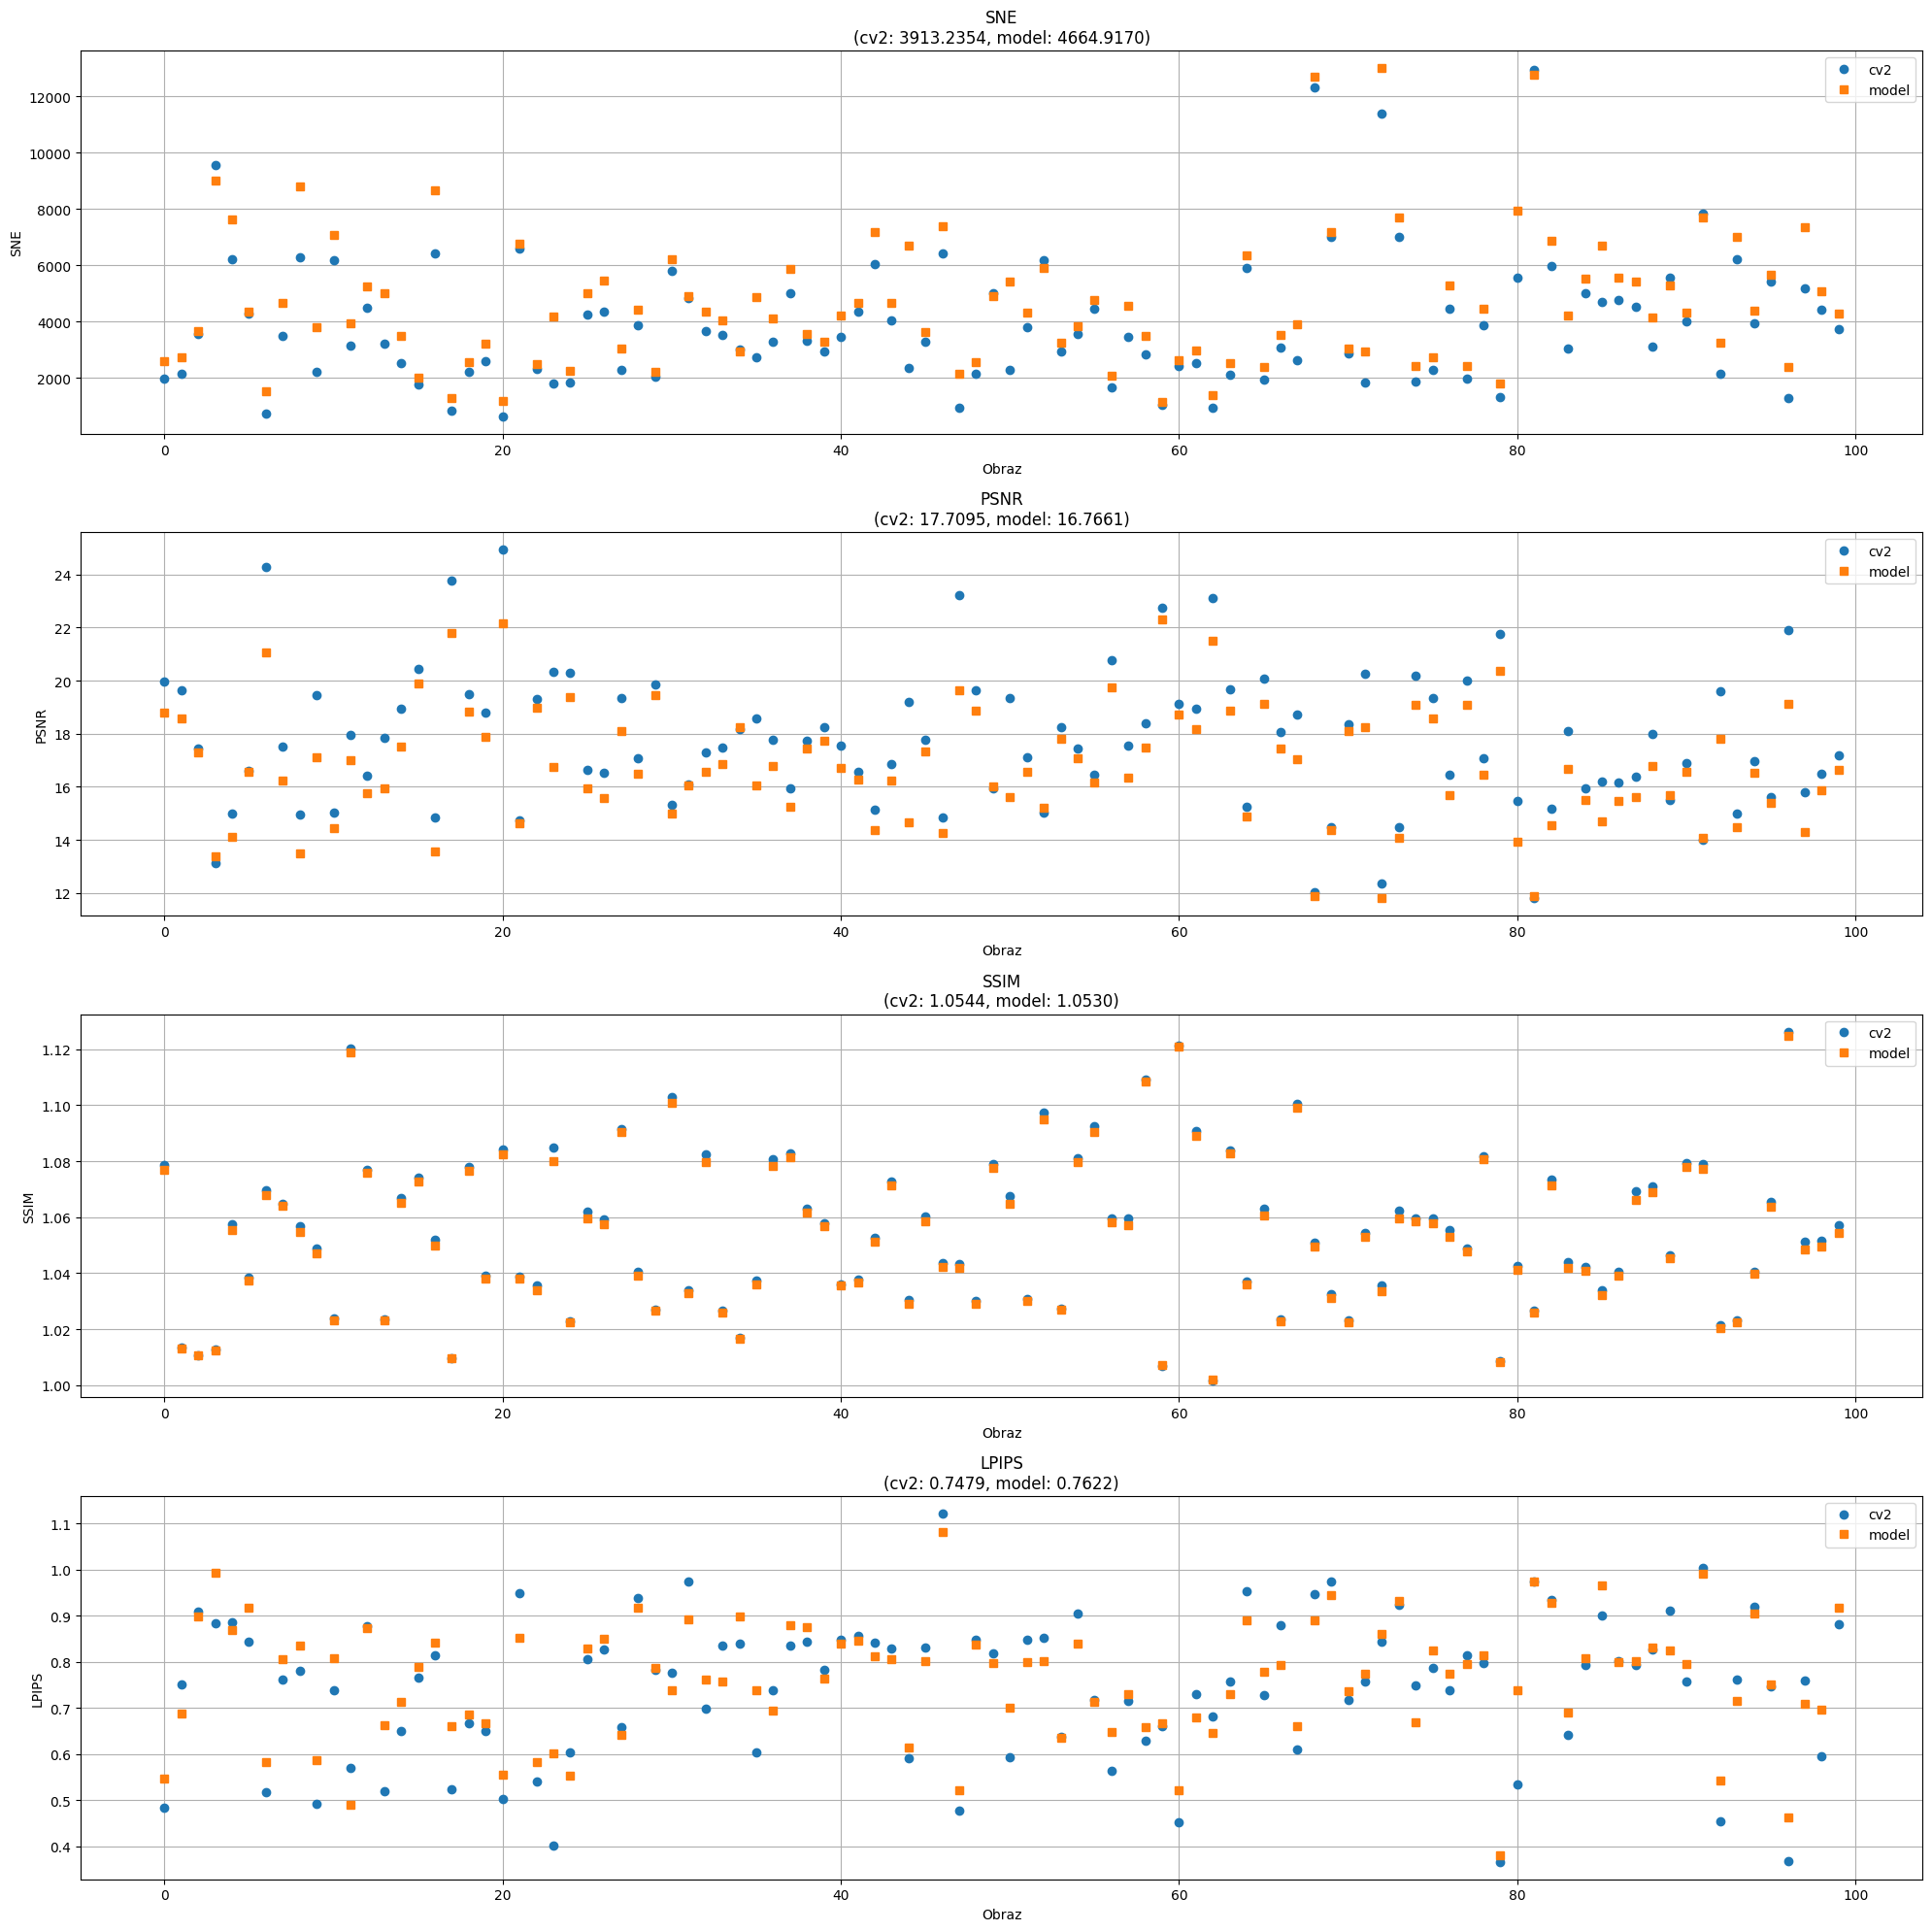

In [ ]:
ground_truth_list = []
cv2_list = []
model_list = []

model.eval()

for x, y in valid_dataset:
    ground_truth_list.append(y.permute(1, 2, 0).detach().numpy())

    cv2_list.append(classic_upscale(x.permute(1, 2, 0).detach().numpy()))

    model_list.append(model(x.to(device)).permute(1, 2, 0).detach().cpu().numpy())


plot_metrics(ground_truth_list, cv2_list, model_list)